            Age  TypeofContact  CityTier  DurationOfPitch  Occupation  Gender  \
0     50.000000            1.0       2.0             15.0         0.0     0.0   
1     56.000000            0.0       1.0             14.0         1.0     0.0   
2     35.814031            1.0       1.0             10.0         0.0     1.0   
3     37.000000            1.0       2.0             18.0         2.0     1.0   
4     48.000000            0.0       3.0             17.0         2.0     1.0   
...         ...            ...       ...              ...         ...     ...   
3484  40.000000            1.0       2.0             26.0         1.0     0.0   
3485  40.000000            1.0       1.0              9.0         0.0     0.0   
3486  31.000000            1.0       1.0             14.0         2.0     1.0   
3487  56.000000            0.0       2.0             15.0         1.0     0.0   
3488  42.000000            1.0       1.0              9.0         2.0     0.0   

      NumberOfPersonVisitin

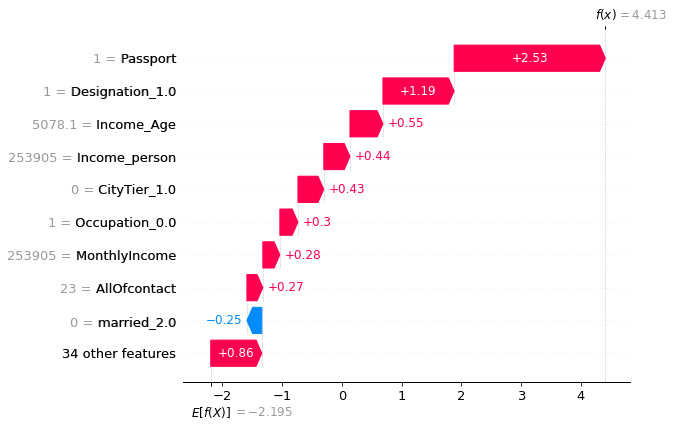

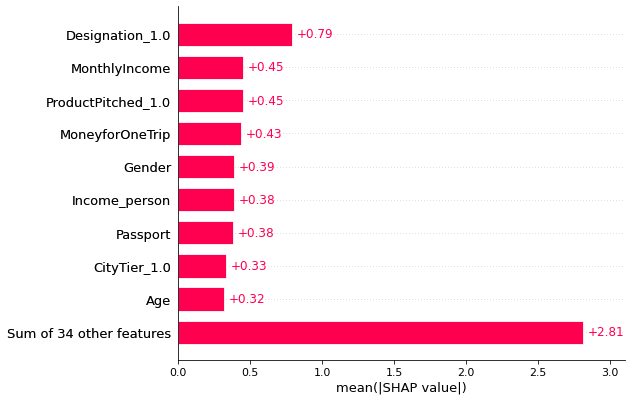

In [4]:

# ====================================================
# Library
# ====================================================
import sys
import os
import gc
import re
import unicodedata
import warnings
warnings.filterwarnings('ignore')
import random
import copy
import scipy as sp
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
import joblib
import pickle
import itertools
from tqdm.auto import tqdm
import category_encoders as ce
import torch
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GroupKFold
from sklearn.metrics import log_loss, roc_auc_score, matthews_corrcoef, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import Callback
from keras.models import clone_model
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',100)

# ====================================================
# Configurations
# ====================================================
class CFG:
    VER = 10
    AUTHOR = 'Naoki'
    COMPETITION = 'SC2024'
    DATA_PATH = Path('/data')
    OOF_DATA_PATH = Path('/oof')
    MODEL_DATA_PATH = Path('/models')
    SUB_DATA_PATH = Path('/submission')
    METHOD_LIST = ['catboost']
    seed = 42
    n_folds = 7
    target_col = 'ProdTaken'
    metric = 'AUC'
    metric_maximize_flag = True
    num_boost_round = 300
    early_stopping_round = 200
    verbose = 25
    classification_lgb_params = {
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,
        'num_leaves' : 15,
        'lambda_l1' : 0.2,
        'lambda_l2' : 0.2,
        'seed': seed,
    }
    classification_xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': 0.05,
        'lambda':2,
        'random_state': seed,
    }

    classification_cat_params = {
        'learning_rate': 0.1,
        'depth':1,
        'l2_leaf_reg' : 6,
        'iterations':1000,
        'random_seed': seed,
    }
    classification_adaboost_params = {
        'n_estimators': 100,
        'learning_rate': 1.0,
        'random_state': 42,
    }
    
    model_weight_dict = {'adaboost': 0.10,'lightgbm': 0.24, 'xgboost': 0.04, 'catboost': 0.72}
    
# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)


# ====================================================
# Metric
# ====================================================
# AUC

# ====================================================
# LightGBM Metric
# ====================================================
def lgb_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'f1score', f1_score(y_true, np.where(y_pred >= 0.5, 1, 0), average='macro'), CFG.metric_maximize_flag

# ====================================================
# XGBoost Metric
# ====================================================
def xgb_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'f1score', f1_score(y_true, np.where(y_pred >= 0.5, 1, 0), average='macro')
#データの読み込み
train_df = pd.read_csv('data/train_processed.csv', index_col=0)
test_df = pd.read_csv('data/test_processed.csv', index_col=0)

#学習に必要となるリストの作成
LabelList = ['TypeofContact','car_possesion','Passport','Gender','PitchSatisfactionScore']
OneHotList = ['CityTier','Occupation','ProductPitched','PreferredPropertyStar','Designation','married']
default_categorical_features = ['TypeofContact','car_possesion','Passport','Gender','PitchSatisfactionScore',
                                'CityTier','Occupation','ProductPitched','PreferredPropertyStar','Designation','married']
default_numerical_features = ['Age','DurationOfPitch','NumberOfPersonVisiting','NumberOfFollowups','NumberOfTrips',
                              'MonthlyIncome','offspring']
'''
NumericalList = ['Age','DurationOfPitch','NumberOfPersonVisiting','NumberOfFollowups','NumberOfTrips','MonthlyIncome','offspring',
               'family_members','Income_person','Child_Rate', 'MoneyforOneTrip','AllOfcontact','PitchPoint','Income_child']
'''
NumericalList = ['Age','DurationOfPitch','NumberOfPersonVisiting','NumberOfFollowups','NumberOfTrips','MonthlyIncome','offspring',
               'family_members','Income_person','Child_Rate', 'MoneyforOneTrip','AllOfcontact','Income_child',
                'Income_Age']

def Preprocessing(train_df, test_df):
    
    def miss_dealing(train_df,test_df):
        #ラベルエンコーディング
        LabelList = ['TypeofContact','Occupation','ProductPitched','Designation','married']
        for col in LabelList:
            encoder = LabelEncoder()
            combined = pd.concat([train_df[col], test_df[col]], axis=0)
            encoder.fit(combined)
            train_df[col] = encoder.transform(train_df[col])
            test_df[col] = encoder.transform(test_df[col])
        features = ['Age','TypeofContact','CityTier','DurationOfPitch','Occupation','Gender','NumberOfPersonVisiting','NumberOfFollowups',
                    'ProductPitched','PreferredPropertyStar','NumberOfTrips','Passport','PitchSatisfactionScore','Designation',
                    'MonthlyIncome','married','car_possesion','offspring']
        train_x = train_df[features]
        imputer = IterativeImputer(max_iter=10, random_state=0)
        imputer.fit(train_x)
        train_x_imputed = imputer.transform(train_x)
        train_df_imputed = pd.DataFrame(train_x_imputed, columns=train_x.columns)
        train_df_imputed[CFG.target_col] = train_df[CFG.target_col]
        test_df_imputed = imputer.transform(test_df)
        test_df_imputed = pd.DataFrame(test_df_imputed, columns=test_df.columns)
        original_index = list(range(3489,6978))
        test_df_imputed.index = original_index
        return train_df_imputed,test_df_imputed
    
     #特徴量作成
    def make_features(input_df):
        df = input_df.copy()
        def count_adult_members(input_str):
            if input_str == 1.0:
                return 2
            else:
                return 1
        
        print(train_df)
        df['family_members'] = df['married'].apply(count_adult_members) + df['offspring']
        df['Child_Rate'] = df['offspring']/df['family_members']
        df['Income_person'] = df['MonthlyIncome']/df['family_members']
        df['Income_child'] =  df['MonthlyIncome']/(df['offspring']+0.0001)
        df['MoneyforOneTrip'] = df['MonthlyIncome']*12/df['NumberOfTrips']
        df['AllOfcontact'] = df['DurationOfPitch'] + df['NumberOfFollowups']*2
        df['Income_Age'] = df['MonthlyIncome'] / df['Age']
        df['Passport_NoCar_Single'] = (df['Passport'] *(1- df['car_possesion']) * df['married'] == 2.0).astype(int)
        

            


        
        return df
    
    

    def encoding(train_df,test_df):
        #ラベルエンコーディング
        for col in LabelList:
            encoder = LabelEncoder()
            combined = pd.concat([train_df[col], test_df[col]], axis=0)
            encoder.fit(combined)
            train_df[col] = encoder.transform(train_df[col])
            test_df[col] = encoder.transform(test_df[col])
        #ワンホットエンコーディング
        train_df2 = train_df.drop([CFG.target_col],axis=1)
        ohe = ce.OneHotEncoder(cols=OneHotList,use_cat_names=True)
        train_df2 = ohe.fit_transform(train_df2)
        test_df = ohe.transform(test_df)
        train_df = pd.concat([train_df2,train_df[CFG.target_col]],axis=1)
        return train_df, test_df
        
    train_df, test_df = miss_dealing(train_df, test_df)
    train_df = make_features(train_df)
    test_df = make_features(test_df)
    print(train_df)
    train_df.info()
    train_df, test_df = encoding(train_df, test_df)
    return train_df, test_df
    
#前処理の実行
train_df, test_df = Preprocessing(train_df,test_df)



#特徴量の指定
features = train_df.columns.tolist()
#学習に使用しない特徴量は以下で除外
RemoveList=[CFG.target_col]
for i in RemoveList:
    features.remove(i)
print(f'features for training:{features}')

#カテゴリカル特徴量の指定
categorical_features = copy.deepcopy(features)
print(NumericalList)
for i in NumericalList:
    categorical_features.remove(i)
print(categorical_features)
model = xgb.XGBClassifier(eval_metric = 'auc')
model.fit(train_df[features],train_df[CFG.target_col])
explainer = shap.Explainer(model)
shap_values = explainer(train_df[features])
shap.plots.waterfall(shap_values[0])

shap.plots.bar(shap_values)





In [5]:
#Learning & Predicting

#1段階目の学習
def Pre_Learning(train_df,test_df, features, categorical_features):
    
    #adaboostでの学習メソッドの定義
    def adaboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features):
        model = AdaBoostClassifier(**CFG.classification_adaboost_params)
        model.fit(x_train, y_train)
        # Predict validation
        valid_pred = model.predict_proba(x_valid)[:, 1]
        return model, valid_pred

    #lightgbmでの学習メソッドの定義
    def lightgbm_training(x_train, y_train, x_valid, y_valid, features, categorical_features):
        lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_features)
        lgb_valid = lgb.Dataset(x_valid, y_valid, categorical_feature=categorical_features)
        model = lgb.train(
                    params = CFG.classification_lgb_params,
                    train_set = lgb_train,
                    num_boost_round = CFG.num_boost_round,
                    valid_sets = [lgb_train, lgb_valid],
                    callbacks=[lgb.early_stopping(stopping_rounds=CFG.early_stopping_round,
                                                  verbose=CFG.verbose)]
                )
        # Predict validation
        valid_pred = model.predict(x_valid)
        return model, valid_pred

    #xgboostでの学習メソッドの定義
    def xgboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features):
        xgb_train = xgb.DMatrix(data=x_train, label=y_train)
        xgb_valid = xgb.DMatrix(data=x_valid, label=y_valid)
        model = xgb.train(
                    CFG.classification_xgb_params,
                    dtrain = xgb_train,
                    num_boost_round = CFG.num_boost_round,
                    evals = [(xgb_train, 'train'), (xgb_valid, 'eval')],
                    early_stopping_rounds = CFG.early_stopping_round,
                    verbose_eval = CFG.verbose,
                    maximize = CFG.metric_maximize_flag,
                )
        # Predict validation
        valid_pred = model.predict(xgb.DMatrix(x_valid))
        return model, valid_pred

    #catboostでの学習メソッドの定義
    def catboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features):
        cat_train = Pool(data=x_train, label=y_train, cat_features=categorical_features)
        cat_valid = Pool(data=x_valid, label=y_valid, cat_features=categorical_features)
        model = CatBoostClassifier(**CFG.classification_cat_params)
        model.fit(cat_train,
                  eval_set = [cat_valid],
                  early_stopping_rounds = CFG.early_stopping_round,
                  verbose = CFG.verbose,
                  use_best_model = True)
        # Predict validation
        valid_pred = model.predict_proba(x_valid)[:, 1]
        return model, valid_pred



    #任意のモデルでのクロスバリデーション学習メソッドの定義
    def gradient_boosting_model_cv_training(method, train_df, features, categorical_features):
        # Create a numpy array to store out of folds predictions
        oof_predictions = np.zeros(len(train_df))
        oof_fold = np.zeros(len(train_df))
        kfold = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
        for fold, (train_index, valid_index) in enumerate(kfold.split(train_df[features],train_df[CFG.target_col])):
            print('-'*50)
            print(f'{method} training fold {fold+1}')

            x_train = train_df[features].iloc[train_index]
            y_train = train_df[CFG.target_col].iloc[train_index]
            x_valid = train_df[features].iloc[valid_index]
            y_valid = train_df[CFG.target_col].iloc[valid_index]

            model = None  # モデル変数を初期化する
            valid_pred = None

            if method == 'adaboost':
                model, valid_pred = adaboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
            if method == 'lightgbm':
                model, valid_pred = lightgbm_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
            if method == 'xgboost':
                model, valid_pred = xgboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
            if method == 'catboost':
                model, valid_pred = catboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features)  
            # Save best model
            pickle.dump(model, open(f'model/{method}_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'wb'))
            # Add to out of folds array
            oof_predictions[valid_index] = valid_pred
            oof_fold[valid_index] = fold + 1
            del x_train, x_valid, y_train, y_valid, model, valid_pred
            gc.collect()

        # Compute out of folds metric
        #score = f1_score(train_df[CFG.target_col], oof_predictions >= 0.5, average='macro')
        score = roc_auc_score(train_df[CFG.target_col], oof_predictions)
        print(f'{method} our out of folds CV AUC is {score}')
        # Create a dataframe to store out of folds predictions
        oof_df = pd.DataFrame({CFG.target_col: train_df[CFG.target_col], f'{method}_prediction': oof_predictions, 'fold': oof_fold})
        oof_df.to_csv(f'oof/oof_{method}_seed{CFG.seed}_ver{CFG.VER}.csv', index = False)

    #adaboostの学習済みモデル読み込み関数
    def adaboost_inference(x_test):
        test_pred = np.zeros(len(x_test))
        for fold in range(CFG.n_folds):
            model = pickle.load(open(f'model/adaboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
            # Predict
            pred = model.predict_proba(x_test)[:, 1]
            test_pred += pred
        return test_pred / CFG.n_folds

    #lightgbmの学習モデル読み込み関数
    def lightgbm_inference(x_test):
        test_pred = np.zeros(len(x_test))
        for fold in range(CFG.n_folds):
            model = pickle.load(open(f'model/lightgbm_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
            # Predict
            pred = model.predict(x_test)
            test_pred += pred
        return test_pred / CFG.n_folds

    #xgboostの学習モデル読み込み関数
    def xgboost_inference(x_test):
        test_pred = np.zeros(len(x_test))
        for fold in range(CFG.n_folds):
            model = pickle.load(open(f'model/xgboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
            # Predict
            pred = model.predict(xgb.DMatrix(x_test))
            test_pred += pred
        return test_pred / CFG.n_folds

    #catboostの学習モデル読み込み関数
    def catboost_inference(x_test):
        test_pred = np.zeros(len(x_test))
        for fold in range(CFG.n_folds):
            model = pickle.load(open(f'model/catboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
            # Predict
            pred = model.predict_proba(x_test)[:, 1]
            test_pred += pred
        return test_pred / CFG.n_folds

    #任意のメソッドに対して予測を返す関数
    def gradient_boosting_model_inference(method, test_df, features, categorical_features):
        x_test = test_df[features]
        if method == 'adaboost':
            test_pred = adaboost_inference(x_test)
        if method == 'lightgbm':
            test_pred = lightgbm_inference(x_test)
        if method == 'xgboost':
            test_pred = xgboost_inference(x_test)
        if method == 'catboost':
            test_pred = catboost_inference(x_test)
        return test_pred

    for method in CFG.METHOD_LIST:
        gradient_boosting_model_cv_training(method, train_df, features, categorical_features)
        test_df[f'{method}_pred_prob'] = gradient_boosting_model_inference(method, test_df, features, categorical_features)
        
        

Pre_Learning(train_df,test_df, features, categorical_features)

test_df['target'] = 0
for method in CFG.METHOD_LIST:
    test_df['target'] += test_df[f'{method}_pred_prob']*CFG.model_weight_dict[method]
    
test_df['target'].to_csv(f'prediction/seed{CFG.seed}_ver{CFG.VER}_{CFG.AUTHOR}_submission.csv', header=False)

--------------------------------------------------
catboost training fold 1
0:	learn: 0.6146532	test: 0.6142634	best: 0.6142634 (0)	total: 4.17ms	remaining: 4.17s
25:	learn: 0.3365216	test: 0.3384804	best: 0.3384804 (25)	total: 232ms	remaining: 8.7s
50:	learn: 0.3182804	test: 0.3196991	best: 0.3196991 (50)	total: 441ms	remaining: 8.2s
75:	learn: 0.3097333	test: 0.3123302	best: 0.3121968 (74)	total: 681ms	remaining: 8.28s
100:	learn: 0.3049783	test: 0.3081162	best: 0.3072652 (92)	total: 896ms	remaining: 7.97s
125:	learn: 0.3015410	test: 0.3048230	best: 0.3048226 (124)	total: 1.09s	remaining: 7.55s
150:	learn: 0.2985213	test: 0.3010044	best: 0.3008746 (148)	total: 1.28s	remaining: 7.19s
175:	learn: 0.2964070	test: 0.2994626	best: 0.2994626 (175)	total: 1.47s	remaining: 6.89s
200:	learn: 0.2941404	test: 0.2987294	best: 0.2985510 (195)	total: 1.68s	remaining: 6.67s
225:	learn: 0.2921103	test: 0.2975333	best: 0.2971810 (217)	total: 1.89s	remaining: 6.47s
250:	learn: 0.2905067	test: 0.296803

150:	learn: 0.2967783	test: 0.3019947	best: 0.3015775 (135)	total: 1.18s	remaining: 6.63s
175:	learn: 0.2943136	test: 0.3008117	best: 0.3008082 (174)	total: 1.4s	remaining: 6.54s
200:	learn: 0.2921450	test: 0.3005185	best: 0.3003200 (199)	total: 1.59s	remaining: 6.32s
225:	learn: 0.2904638	test: 0.3012013	best: 0.3003200 (199)	total: 1.79s	remaining: 6.14s
250:	learn: 0.2892214	test: 0.3012827	best: 0.3003200 (199)	total: 2.01s	remaining: 6s
275:	learn: 0.2883189	test: 0.3013852	best: 0.3003200 (199)	total: 2.2s	remaining: 5.77s
300:	learn: 0.2873016	test: 0.3016106	best: 0.3003200 (199)	total: 2.44s	remaining: 5.67s
325:	learn: 0.2862473	test: 0.3017671	best: 0.3003200 (199)	total: 2.69s	remaining: 5.56s
350:	learn: 0.2852387	test: 0.3015731	best: 0.3003200 (199)	total: 2.92s	remaining: 5.4s
375:	learn: 0.2841924	test: 0.3015247	best: 0.3003200 (199)	total: 3.13s	remaining: 5.2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3003200083
bestIteration = 199

Shrink

675:	learn: 0.2828327	test: 0.2681409	best: 0.2677712 (623)	total: 5.57s	remaining: 2.67s
700:	learn: 0.2823600	test: 0.2678298	best: 0.2677527 (691)	total: 5.79s	remaining: 2.47s
725:	learn: 0.2819077	test: 0.2676995	best: 0.2676207 (716)	total: 6s	remaining: 2.26s
750:	learn: 0.2815742	test: 0.2679016	best: 0.2675548 (728)	total: 6.19s	remaining: 2.05s
775:	learn: 0.2811927	test: 0.2679283	best: 0.2675548 (728)	total: 6.4s	remaining: 1.85s
800:	learn: 0.2807937	test: 0.2677332	best: 0.2675548 (728)	total: 6.61s	remaining: 1.64s
825:	learn: 0.2804328	test: 0.2677371	best: 0.2675548 (728)	total: 6.79s	remaining: 1.43s
850:	learn: 0.2800954	test: 0.2676941	best: 0.2674833 (846)	total: 6.98s	remaining: 1.22s
875:	learn: 0.2797845	test: 0.2677380	best: 0.2674616 (868)	total: 7.19s	remaining: 1.02s
900:	learn: 0.2794247	test: 0.2675184	best: 0.2673237 (894)	total: 7.39s	remaining: 812ms
925:	learn: 0.2790806	test: 0.2678156	best: 0.2673237 (894)	total: 7.59s	remaining: 607ms
950:	learn: 0.

In [6]:
model = pickle.load(open(f'model/catboost_fold1_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
feature_importances = model.get_feature_importance()
feature_importances_df = pd.DataFrame({
    'Feature':train_df[features].columns,
    'Importance': feature_importances}).sort_values(by = 'Importance',ascending=False)
print(feature_importances_df)

non_zero_feature_importances_df = feature_importances_df[feature_importances_df['Importance']==0.0]
non_zero_feature_importances_df_list = non_zero_feature_importances_df['Feature'].tolist()
print(len(non_zero_feature_importances_df_list),non_zero_feature_importances_df_list)

                      Feature  Importance
23            Designation_1.0   19.826389
21                   Passport    8.930645
32                married_2.0    8.278718
15         ProductPitched_1.0    7.201809
28              MonthlyIncome    6.588372
12         ProductPitched_0.0    5.619357
9                      Gender    5.311653
40               AllOfcontact    5.129960
37              Income_person    4.150738
0                         Age    4.142043
3                CityTier_1.0    3.645563
39            MoneyforOneTrip    3.588179
5             DurationOfPitch    2.908037
41                 Income_Age    2.194609
26            Designation_2.0    2.075400
1               TypeofContact    1.768329
20              NumberOfTrips    1.691624
38               Income_child    1.567156
22     PitchSatisfactionScore    1.472020
11          NumberOfFollowups    1.244319
18  PreferredPropertyStar_4.0    0.939154
33              car_possesion    0.671574
6              Occupation_0.0    0